In [2]:
import sys
sys.path.insert(0, '../../')

import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import schedule as sch
import topo
import typing
import utils
import yaml
import time
from tqdm.notebook import tqdm

matplotlib.rc('font', family='Times New Roman', size=18)

In [3]:
def unit_size_cb(r: int):
    return 10000 * math.pow(10, random.randint(0, 1))

def timer(f):
    t0 = time.time()
    f()
    t1 = time.time()
    return t1 - t0

def gen_graphs(graph_count, source_selector_dict, max_source_num):
    source_selector = graph.MultiDomainSourceSelector(source_selector_dict)
    global source_quota
    source_quota = max_source_num
    def source_num(i):
        global source_quota
        assert graph_count - i <= source_quota
        delta = source_quota - (graph_count - i)
        ret = 1 + random.randint(0, min(delta, 2))
        source_quota -= ret
        return ret
    gen_args_list = [
            {
            "total_rank": random.randint(3, 7),
            "max_node_per_rank": random.randint(1, 3),
            "max_predecessors": random.randint(1, 2),
            "mi_cb": lambda: 1,
            "memory_cb": lambda: int(2e8),
            "unit_size_cb": unit_size_cb,
            "unit_rate_cb": lambda: random.randint(10, 20),
            "source_hosts": source_selector,
            "sink_hosts": ["cloud1"],
            "sources_num": source_num(i),
        }
        for i in range(graph_count)
    ]
    return [
        graph.MultiSourceGraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
        for idx, gen_args in enumerate(gen_args_list)
    ]

In [4]:
def big_avg(array):
    return sum(array) / len(array)

from tqdm.notebook import trange
def run(sc, labels, source_selector_dict, max_source_num):
    flow_time = [[] for _ in labels]
    sbon_time = [[] for _ in labels]
    test_round = 100
    for idx, graph_count in enumerate(labels):
        print(graph_count)
        for _ in trange(test_round, desc="running with {} graphs".format(graph_count)):
            graph_list = gen_graphs(graph_count, source_selector_dict, max_source_num)
            
            sc.topo.clear_occupied()
            flow_scheduler = sch.MultiEdgeFlowScheduler(sc)
            flow_time_1_round = timer(lambda: flow_scheduler.schedule_multiple(graph_list))
            flow_time[idx].append(flow_time_1_round)

            sc.topo.clear_occupied()
            sbon_scheduler = sch.MultiEdgeSbonScheduler(sc)
            sbon_time_1_round = timer(lambda: sbon_scheduler.schedule_multiple(graph_list))
            sbon_time[idx].append(sbon_time_1_round)
            
                
    flow_time = [big_avg(i) for i in flow_time]
    sbon_time = [big_avg(i) for i in sbon_time]
    # return flow_event_data, flow_bp_data, all_cloud_event_data, all_cloud_bp_data, sbon_event_data, sbon_bp_data
    return flow_time, sbon_time

In [5]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e6h.yaml", "r").read(), Loader=yaml.Loader))
f_time1, sbon_time1 = run(sc, [4, 8, 12, 16, 20], 
        {"edge0": {'e0rasp1': 10, 'e0rasp2': 10, 'e0rasp3': 10},
        "edge1": {'e1rasp1': 10, 'e1rasp2': 10, 'e1rasp3': 10}}, 45)
print(f_time1)
print(sbon_time1)

4


running with 4 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

8


running with 8 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

12


running with 12 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

16


running with 16 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

20


running with 20 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[0.01354346513748169, 0.023416943550109863, 0.029388418197631837, 0.03931081533432007, 0.04949249505996704]
[0.1848645353317261, 0.32158573627471926, 0.42831053495407106, 0.5762490057945251, 0.698551459312439]


In [6]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e18h.yaml", "r").read(), Loader=yaml.Loader))
edge0 = {"e0rasp"+str(i): 12 for i in range(1, 7)}
edge1 = {"e1rasp"+str(i): 12 for i in range(1, 4)}
edge1.update({"e1vm"+str(i): 24 for i in range(1, 4)})
edge2 = {"e2rasp"+str(i): 12 for i in range(1, 5)}
edge2.update({"e2vm"+str(i): 24 for i in range(1, 3)})
source_dict = {"edge0": edge0, "edge1": edge1, "edge2": edge2}
f_time2, sbon_time2 = run(sc, [40, 60, 80, 100, 120], source_dict, 200)
print(f_time2)
print(sbon_time2)

40


running with 40 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

60


running with 60 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

80


running with 80 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

100


running with 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

120


running with 120 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[0.09332764387130738, 0.15515031099319457, 0.23237598657608033, 0.349429624080658, 0.38146514892578126]
[1.297893204689026, 1.9235706996917725, 2.6282938575744628, 3.3211379933357237, 4.000629048347474]


In [9]:
import json
data = {
    "f_time1": f_time1,
    "f_time2": f_time2,
    "sbon_time1": sbon_time1,
    "sbon_time2": sbon_time2
}
with open("lat_time.json", "w") as f:
    f.write(json.dumps(data))

In [17]:
with open("lat_time.json", "r") as f:
    data = json.loads(f.read())
    f_time1 = data["f_time1"]
    f_time2 = data["f_time2"]
    sbon_time1 = data["sbon_time1"]
    sbon_time2 = data["sbon_time2"]

In [20]:
def s_2_ms(data):
    ret = []
    for i in range(len(data)):
        ret.append(data[i] * 1000)
    return ret

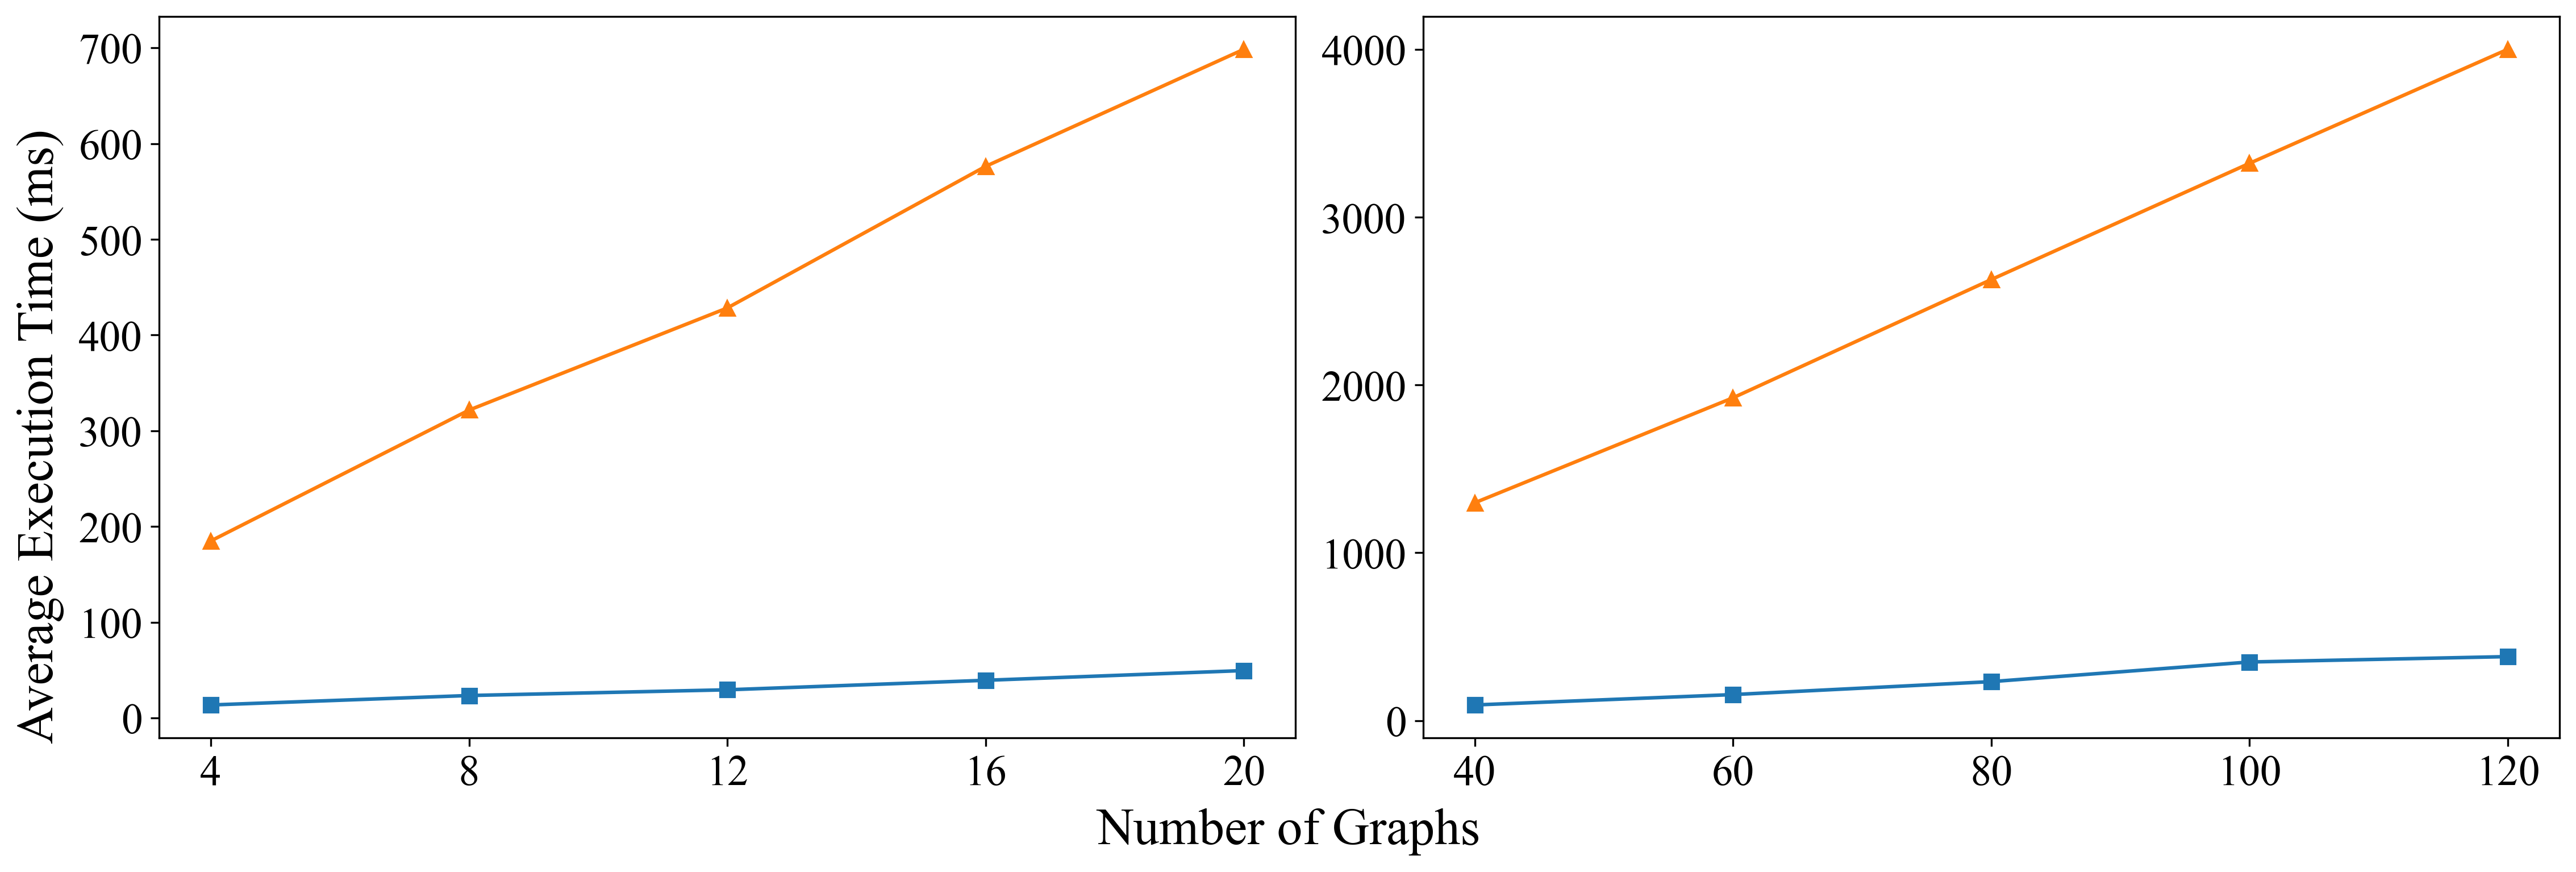

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300, constrained_layout=True)
fig.supxlabel("Number of Graphs")
fig.supylabel("Average Execution Time (ms)")
axes[0].set_xticks([i for i in range(5)])
axes[0].set_xticklabels([4, 8, 12, 16, 20])
axes[1].set_xticks([i for i in range(5)])
axes[1].set_xticklabels([40, 60, 80, 100, 120])
axes[0].plot(s_2_ms(f_time1), marker="s")
axes[0].plot(s_2_ms(sbon_time1), marker="^")
axes[1].plot(s_2_ms(f_time2), marker="s")
axes[1].plot(s_2_ms(sbon_time2), marker="^")
plt.show()